#딥러닝 final project

2022320009 이수현

# 데이터 준비

In [1]:
# kaggle.json 파일 올려야함
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#kaggle에서 데이터 가져오기
!kaggle datasets download -d neha1703/movie-genre-from-its-poster

!unzip movie-genre-from-its-poster.zip -d ./movie_genre_data

Dataset URL: https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster
License(s): unknown
100% 35.9M/35.9M [00:02<00:00, 22.6MB/s]
100% 35.9M/35.9M [00:02<00:00, 13.8MB/s]
Archive:  movie-genre-from-its-poster.zip
  inflating: ./movie_genre_data/MovieGenre.csv  
  inflating: ./movie_genre_data/SampleMoviePosters/SampleMoviePosters/10040.jpg  
  inflating: ./movie_genre_data/SampleMoviePosters/SampleMoviePosters/10057.jpg  
  inflating: ./movie_genre_data/SampleMoviePosters/SampleMoviePosters/10071.jpg  
  inflating: ./movie_genre_data/SampleMoviePosters/SampleMoviePosters/10155.jpg  
  inflating: ./movie_genre_data/SampleMoviePosters/SampleMoviePosters/10195.jpg  
  inflating: ./movie_genre_data/SampleMoviePosters/SampleMoviePosters/10208.jpg  
  inflating: ./movie_genre_data/SampleMoviePosters/SampleMoviePosters/10247.jpg  
  inflating: ./movie_genre_data/SampleMoviePosters/SampleMoviePosters/10267.jpg  
  inflating: ./movie_genre_data/SampleMoviePosters/SampleMoviePosters

In [3]:
import os

#파일 확인!
dataset_path = "./movie_genre_data"
print(os.listdir(dataset_path))

['SampleMoviePosters', 'samplemovieposters', 'MovieGenre.csv']


## 데이터 전처리 및 데이터 확인

* 파일을 살펴보다가 중복을 발견
* SampleMoviePosters와 samplemovieposters가 중복 (전체 파일 중복) -> samplemovieposters 삭제

[데이터확인]

* 총 영화 포스터의 개수 : SampleMoviePosters안에 있는 jpg파일 개수 확인
* 영화 장르가 적혀있는 csv 파일 확인

In [ ]:
import shutil
import os

#samplemovieposters 파일 삭제
path_to_duplicate = "./movie_genre_data/samplemovieposters"
if os.path.exists(path_to_duplicate):
    shutil.rmtree(path_to_duplicate)
    print(f"{path_to_duplicate} 삭제 완료.")
else:
    print("중복 폴더가 없습니다.")

./movie_genre_data/samplemovieposters 삭제 완료.


In [ ]:
#파일 안에 영화 포스터 개수 세기
movieposter_path = "./movie_genre_data/SampleMoviePosters/SampleMoviePosters"

poster_files = [file for file in os.listdir(movieposter_path) if file.endswith('.jpg')]
poster_count = len(poster_files)

print(f"총 JPG 파일 개수: {poster_count}") #997개

총 JPG 파일 개수: 997


In [ ]:
#장르csv파일 확인
import pandas as pd
genrecsv_path = "./movie_genre_data/MovieGenre.csv"
data = pd.read_csv(genrecsv_path, encoding="latin1")

print(data.columns) #Index(['imdbId', 'Imdb Link', 'Title', 'IMDB Score', 'Genre', 'Poster'], dtype='object')

Index(['imdbId', 'Imdb Link', 'Title', 'IMDB Score', 'Genre', 'Poster'], dtype='object')


MovieGenre.csv 파일 확인
* column은 'imdbId', 'Imdb Link', 'Title', 'IMDB Score', 'Genre', 'Poster' 로 구성
* 수동 확인 끝에 영화 포스터 이미지의 제목 = imdbId임을 확인
ex. 10057.jpg는 imdbId가 10057의 영화 포스터
* 필요한 정보는 imdbId, Genre.
* 두 정보를 제외하고 모두 삭제

In [ ]:
#imdbId, Genre만 선택

genredata = data[["imdbId", "Genre"]]
print(genredata.head())

   imdbId                       Genre
0  114709  Animation|Adventure|Comedy
1  113497     Action|Adventure|Family
2  113228              Comedy|Romance
3  114885        Comedy|Drama|Romance
4  113041       Comedy|Family|Romance


* 한 영화에 여러 장르가 중복인 것을 확인
* 장르 정보 알아보기

In [ ]:
from collections import Counter

# 'Genre' 열의 값을 '|' 기준으로 분리하고 평탄화
all_genres = [genre for genres in genredata["Genre"].dropna() for genre in genres.split('|')]

genre_counts = Counter(all_genres)
genre_list = list(genre_counts.keys())
genre_total_count = len(genre_list)

print(f"장르 개수: {genre_total_count}")
print(f"장르 목록: {genre_list}")
print("\n장르별 영화 개수:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

장르 개수: 28
장르 목록: ['Animation', 'Adventure', 'Comedy', 'Action', 'Family', 'Romance', 'Drama', 'Crime', 'Thriller', 'Fantasy', 'Horror', 'Biography', 'History', 'Mystery', 'Sci-Fi', 'War', 'Sport', 'Music', 'Documentary', 'Musical', 'Western', 'Short', 'Film-Noir', 'Talk-Show', 'News', 'Adult', 'Reality-TV', 'Game-Show']

장르별 영화 개수:
Animation: 1750
Adventure: 3829
Comedy: 12682
Action: 5331
Family: 2100
Romance: 6224
Drama: 20053
Crime: 5270
Thriller: 4816
Fantasy: 2012
Horror: 3990
Biography: 1999
History: 1426
Mystery: 2395
Sci-Fi: 2020
War: 1173
Sport: 707
Music: 1292
Documentary: 3882
Musical: 845
Western: 853
Short: 1066
Film-Noir: 403
Talk-Show: 7
News: 83
Adult: 14
Reality-TV: 2
Game-Show: 1


MovieGenre.csv.파일 분석
* 한 영화에 장르가 여러개 -> split : genre를 이진 벡터로 mapping
* 실제로 이미지가 있는지 확인
* 장르별 영화 개수가 불균형적 ->
    1. 각 장르에 영화 포스터가 30개 미만인 것은 삭제
    2. 각 장르에 영화 포스터가 200개 미만인 것은 oversampling와 데이터 증강을 이용


In [ ]:
# genre를 -> 이진 벡터로 mapping

import pandas as pd
def convert_to_multilabel_vector(row_genres, genre_list):
    if pd.isna(row_genres):  # NaN 값 확인
        return [0] * len(genre_list)  # 모든 장르에 대해 0으로 설정
    genres = row_genres.split('|')
    return [1 if genre in genres else 0 for genre in genre_list]

genredata["Genre_Vector"] = genredata["Genre"].apply(lambda x: convert_to_multilabel_vector(x, genre_list))
genredata = genredata.dropna(subset=["Genre"]) #혹시 모를 결측치 제거

# 결과 확인
print(genredata.head())

   imdbId                       Genre  \
0  114709  Animation|Adventure|Comedy   
1  113497     Action|Adventure|Family   
2  113228              Comedy|Romance   
3  114885        Comedy|Drama|Romance   
4  113041       Comedy|Family|Romance   

                                        Genre_Vector  
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


<ipython-input-9-b2f5e9e9e0b7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genredata["Genre_Vector"] = genredata["Genre"].apply(lambda x: convert_to_multilabel_vector(x, genre_list))


In [ ]:
import os
import pandas as pd

# 이미지 경로
image_dir = "./movie_genre_data/SampleMoviePosters/SampleMoviePosters"

# 이미지 파일 존재 여부 체크
def image_exists(imdbId):
    image_path = os.path.join(image_dir, f"{imdbId}.jpg")
    return os.path.exists(image_path)

# 실제 이미지가 존재하는 행만 필터링
genredata_with_images = genredata[genredata["imdbId"].astype(str).apply(image_exists)]

print(f"이미지 존재하는 데이터 개수: {len(genredata_with_images)}")

이미지 존재하는 데이터 개수: 1018


In [ ]:
#각 장르별 이미지 개수
from collections import Counter

# 각 장르별로 영화 개수를 계산하기 위해 '|'로 구분된 장르를 분리
all_genres_with_images = [
    genre
    for genres in genredata_with_images["Genre"]
    for genre in genres.split('|')
]

# 각 장르별 영화 포스터 개수 계산
genre_counts_with_images = Counter(all_genres_with_images)

# 결과 출력
print("이미지가 존재하는 각 장르별 영화 포스터 개수:")
for genre, count in genre_counts_with_images.items():
    print(f"{genre}: {count}")

이미지가 존재하는 각 장르별 영화 포스터 개수:
Drama: 601
Romance: 317
Comedy: 372
Musical: 58
War: 38
Crime: 115
Mystery: 61
Fantasy: 45
Horror: 61
Western: 42
Sci-Fi: 11
Animation: 28
Family: 44
Thriller: 33
Biography: 21
Music: 9
Adventure: 81
Sport: 14
Action: 44
Documentary: 18
Short: 112
History: 41
Film-Noir: 13


In [ ]:
# 30개 이하 장르 필터링
valid_genres = {genre for genre, count in genre_counts_with_images.items() if count > 30}

def filter_small_genres(row_genres, valid_genres):
    genres = row_genres.split('|')
    return '|'.join([genre for genre in genres if genre in valid_genres]) or None

# 30개 이하 장르 제거
genredata_with_images["Filtered_Genre"] = genredata_with_images["Genre"].apply(
    lambda x: filter_small_genres(x, valid_genres)
)
genredata_filtered = genredata_with_images.dropna(subset=["Filtered_Genre"])

print(f"30개 이하 장르 제거 후 데이터 개수: {len(genredata_filtered)}")

30개 이하 장르 제거 후 데이터 개수: 1006


<ipython-input-12-d91a0f6b7891>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genredata_with_images["Filtered_Genre"] = genredata_with_images["Genre"].apply(


In [ ]:
# 각 장르별 영화 포스터 개수 재계산
filtered_genre_counts = Counter(
    genre
    for genres in genredata_filtered["Filtered_Genre"]
    for genre in genres.split('|')
)

# 200개 이하인 장르 목록
genres_to_augment = [genre for genre, count in filtered_genre_counts.items() if count < 200]

print(f"증강 대상 장르: {genres_to_augment}")

# 증강 함수 정의
import os
from PIL import Image
from torchvision import transforms

def apply_augmentation_for_target_genres(genre, dataset, save_dir, augment_count=5):
    """
    증강 대상 장르에만 해당하는 이미지를 증강
    """
    os.makedirs(save_dir, exist_ok=True)
    augmentation_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor()
    ])

    # 해당 장르만 포함하는 데이터 필터링
    genre_data = dataset[dataset["Filtered_Genre"].str.contains(genre)]
    for _, row in genre_data.iterrows():
        image_path = os.path.join(image_dir, f"{row['imdbId']}.jpg")
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('RGB')
            for i in range(augment_count):
                # 증강 이미지 저장
                augmented_image = augmentation_transform(image)
                augmented_image_pil = transforms.ToPILImage()(augmented_image)
                augmented_image_pil.save(os.path.join(save_dir, f"{genre}_aug_{i}_{row['imdbId']}.jpg"))

# 실행: 증강 대상 장르만 증강
for genre in genres_to_augment:
    apply_augmentation_for_target_genres(
        genre,
        genredata_filtered,
        save_dir=f"./augmented_data/{genre}",
        augment_count=5
    )


증강 대상 장르: ['Musical', 'War', 'Crime', 'Mystery', 'Fantasy', 'Horror', 'Western', 'Family', 'Thriller', 'Adventure', 'Action', 'Short', 'History']


In [ ]:
# 최종 데이터셋 병합
final_dataset_path = "./final_dataset"
os.makedirs(final_dataset_path, exist_ok=True)

# 원본 데이터 복사
for _, row in genredata_filtered.iterrows():
    original_image_path = os.path.join(image_dir, f"{row['imdbId']}.jpg")
    if os.path.exists(original_image_path):
        shutil.copy(original_image_path, final_dataset_path)

# 증강 데이터 복사 (증강 대상 장르만 반영)
augmented_dirs = [f"./augmented_data/{genre}" for genre in genres_to_augment]
for dir_path in augmented_dirs:
    if os.path.exists(dir_path):
        for file in os.listdir(dir_path):
            # 증강된 이미지만 복사
            shutil.copy(os.path.join(dir_path, file), final_dataset_path)

# 최종 데이터셋 이미지 수 출력
print(f"최종 데이터셋 이미지 수: {len(os.listdir(final_dataset_path))}")


최종 데이터셋 이미지 수: 4725


In [ ]:
# 최종 데이터셋 이미지 파일 수집
final_image_files = [f for f in os.listdir(final_dataset_path) if f.endswith('.jpg')]

# imdbId 추출 함수 (증강 이미지도 동일한 형식 처리)
def extract_imdbId_from_filename(filename):
    parts = filename.split('_')
    imdbId = parts[-1].split('.')[0]  # 확장자 제외한 imdbId 추출
    return imdbId

image_genre_counts = Counter()

for file in final_image_files:
    imdbId = extract_imdbId_from_filename(file)
    # 증강 데이터 여부 확인
    is_augmented = '_aug_' in file
    row = genredata_filtered[genredata_filtered["imdbId"].astype(str) == imdbId]
    if not row.empty:
        genres = row.iloc[0]["Filtered_Genre"].split('|')
        if is_augmented:
            # 증강 대상 장르만 카운트
            for g in genres:
                if g in genres_to_augment:
                    image_genre_counts[g] += 1
        else:
            # 원본 이미지는 모든 장르를 카운트
            for g in genres:
                image_genre_counts[g] += 1

# 결과 출력
print("증강 반영 후 최종 장르별 이미지 개수:")
for genre, count in image_genre_counts.items():
    print(f"{genre}: {count}")

증강 반영 후 최종 장르별 이미지 개수:
Comedy: 367
Short: 792
Family: 393
Western: 288
Crime: 977
Mystery: 650
Horror: 604
Fantasy: 490
War: 266
Thriller: 342
Romance: 308
Drama: 589
History: 278
Action: 436
Adventure: 746
Musical: 356


* 각 장르에서 250개의 데이터만 사용하기록 결정

In [ ]:
# 장르 리스트 (image_genre_counts의 key를 이용)
genre_list = list(image_genre_counts.keys())
genre_to_idx = {g: i for i, g in enumerate(genre_list)}

print("장르 리스트:", genre_list)
print("장르 인덱스 매핑:", genre_to_idx)


장르 리스트: ['Comedy', 'Short', 'Family', 'Western', 'Crime', 'Mystery', 'Horror', 'Fantasy', 'War', 'Thriller', 'Romance', 'Drama', 'History', 'Action', 'Adventure', 'Musical']
장르 인덱스 매핑: {'Comedy': 0, 'Short': 1, 'Family': 2, 'Western': 3, 'Crime': 4, 'Mystery': 5, 'Horror': 6, 'Fantasy': 7, 'War': 8, 'Thriller': 9, 'Romance': 10, 'Drama': 11, 'History': 12, 'Action': 13, 'Adventure': 14, 'Musical': 15}


In [ ]:
imdbId_to_genres = {}
for _, row in genredata_filtered.iterrows():
    imdbId = str(row['imdbId'])
    genres = row['Filtered_Genre'].split('|')
    imdbId_to_genres[imdbId] = genres


In [ ]:
# 각 장르에서 250개씩

import os
import random
from collections import defaultdict

final_dataset_path = "./final_dataset"
final_image_files = [f for f in os.listdir(final_dataset_path) if f.endswith('.jpg')]

# 장르별 파일 리스트
genre_to_files = defaultdict(list)

for file in final_image_files:
    imdbId = extract_imdbId_from_filename(file)
    if imdbId in imdbId_to_genres:
        genres = imdbId_to_genres[imdbId]
        for g in genres:
            if g in genre_list:
                genre_to_files[g].append(file)

# 각 장르에서 250개씩만 샘플링
sampled_files = []
for g in genre_list:
    selected = random.sample(genre_to_files[g], min(250, len(genre_to_files[g])))
    sampled_files.extend(selected)

print(f"샘플링된 총 이미지 수: {len(sampled_files)}") #4000


샘플링된 총 이미지 수: 4000


In [ ]:
import shutil

final_sampled_dataset_path = "./final_sampled_dataset"
os.makedirs(final_sampled_dataset_path, exist_ok=True)

for f in sampled_files:
    shutil.copy(os.path.join(final_dataset_path, f), final_sampled_dataset_path)

print(f"최종 샘플링 데이터셋 이미지 수: {len(os.listdir(final_sampled_dataset_path))}") #3068


최종 샘플링 데이터셋 이미지 수: 3022


* train / val / test set 분할 : 80 : 10

In [ ]:
all_sampled_files = os.listdir(final_sampled_dataset_path)
random.shuffle(all_sampled_files)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

total_count = len(all_sampled_files)
train_count = int(total_count * train_ratio)
val_count = int(total_count * val_ratio)
test_count = total_count - train_count - val_count

train_files = all_sampled_files[:train_count]
val_files = all_sampled_files[train_count:train_count+val_count]
test_files = all_sampled_files[train_count+val_count:]

train_dir = "./final_sampled_dataset/train"
val_dir = "./final_sampled_dataset/val"
test_dir = "./final_sampled_dataset/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for f in train_files:
    shutil.copy(os.path.join(final_sampled_dataset_path, f), train_dir)
for f in val_files:
    shutil.copy(os.path.join(final_sampled_dataset_path, f), val_dir)
for f in test_files:
    shutil.copy(os.path.join(final_sampled_dataset_path, f), test_dir)

print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

Train: 2417, Val: 302, Test: 303


## dataloader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image


def get_label_vector(genres, genre_to_idx):
    vec = torch.zeros(len(genre_to_idx))
    for g in genres:
        if g in genre_to_idx:
            vec[genre_to_idx[g]] = 1
    return vec

class MoviePosterDataset(Dataset):
    def __init__(self, image_dir, file_list, imdbId_to_genres, processor, genre_to_idx):
        self.image_dir = image_dir
        self.file_list = file_list
        self.imdbId_to_genres = imdbId_to_genres
        self.processor = processor
        self.genre_to_idx = genre_to_idx

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        image_path = os.path.join(self.image_dir, file_name)
        image = Image.open(image_path).convert("RGB")

        # imdbId 추출
        imdbId = file_name.split('_')[-1].split('.')[0]
        genres = self.imdbId_to_genres[imdbId]

        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)  # [3,224,224]

        labels = get_label_vector(genres, self.genre_to_idx)

        return pixel_values, labels


In [ ]:
from transformers import CLIPModel, CLIPProcessor

model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
train_dir = "./final_sampled_dataset/train"
val_dir = "./final_sampled_dataset/val"
test_dir = "./final_sampled_dataset/test"

train_files = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
val_files = [f for f in os.listdir(val_dir) if f.endswith('.jpg')]
test_files = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]

train_dataset = MoviePosterDataset(train_dir, train_files, imdbId_to_genres, processor, genre_to_idx)
val_dataset = MoviePosterDataset(val_dir, val_files, imdbId_to_genres, processor, genre_to_idx)
test_dataset = MoviePosterDataset(test_dir, test_files, imdbId_to_genres, processor, genre_to_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# CLIP 모델 구현

In [ ]:
#CLIP 모델 로드 및 Multi-label Head 추가
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor

model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# genre_list, genre_to_idx, imdbId_to_genres 등은 이전과 동일하게 준비되었다고 가정
num_classes = len(genre_list)

########################################
# Multi-Head Architecture 구현
########################################

class CLIPMultiHeadModel(nn.Module):
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.vision_model = clip_model.vision_model

        # CLIP 모델의 Vision Encoder 출력 차원 가져오기
        feature_dim = self.vision_model.config.hidden_size

        # 각 장르별로 독립적인 Linear Layer를 생성
        # ModuleList를 사용하여 각 장르별 헤드를 저장
        self.heads = nn.ModuleList([nn.Linear(feature_dim, 1) for _ in range(num_classes)])

    def forward(self, pixel_values):
        # Vision Encoder Forward
        outputs = self.vision_model(pixel_values)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token 특징 추출

        # 각 장르에 대해 독립적으로 로짓 계산
        logits_list = []
        for head in self.heads:
            logits = head(pooled_output)  # shape: [batch, 1]
            logits_list.append(logits)

        # [batch, num_classes] 형태로 합치기
        # logits_list: list of [batch, 1] -> cat -> [batch, num_classes]
        logits = torch.cat(logits_list, dim=1)
        return logits

model = CLIPMultiHeadModel(clip_model, num_classes).to(device)

# 학습 설계 -> 여기에 classifier chain을 추가
* classifier chain은 레이블의 순서에 굉장히 민감
* 장르 관계 분석 후 순서 결정 -> classifier chain을 추가

In [ ]:
# 1. 장르 관계 분석
# clip의 텍스트 인코더를 사용하여 장르 리스트의 임베딩 -> 코사인 유사도 -> 유사한 장르 끼리 chain 순서로
genre_list = list(image_genre_counts.keys())

import torch
import numpy as np
from transformers import CLIPTokenizer, CLIPModel

model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
tokenizer = CLIPTokenizer.from_pretrained(model_name)
text_encoder = clip_model.text_model

# 장르 임베딩 추출
with torch.no_grad():
    tokens = tokenizer(genre_list, return_tensors="pt", padding=True)
    text_outputs = text_encoder(**tokens)
    # 첫 번째 토큰(CLS) 임베딩 사용
    text_embeddings = text_outputs.last_hidden_state[:, 0, :]  # shape: [num_genres, hidden_dim]

# 코사인 유사도 계산
norm_text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
similarity = norm_text_embeddings @ norm_text_embeddings.T  # [num_genres, num_genres]

# Chain 순서 결정: 간단히 "가장 유사한 장르를 순차적으로 연결"하는 방식
chain_order = []
available = set(range(len(genre_list)))
current = 0  # 시작 장르 인덱스 (임의로 0)
chain_order.append(current)
available.remove(current)

while available:
    sims = similarity[current].cpu().numpy()
    # 아직 선택되지 않은 장르 중 가장 유사도가 높은 장르를 선택
    next_genre = max(available, key=lambda x: sims[x])
    chain_order.append(next_genre)
    available.remove(next_genre)
    current = next_genre

ordered_genres = [genre_list[i] for i in chain_order]
print("Classifier Chain 순서:", ordered_genres)
# 이 순서를 classifier chain에 적용해야함

Classifier Chain 순서: ['Comedy', 'Short', 'Family', 'Western', 'Crime', 'Mystery', 'Horror', 'Fantasy', 'War', 'Thriller', 'Romance', 'Drama', 'History', 'Action', 'Adventure', 'Musical']


* ordered_genres를 활용하여
* 각 장르별 Head는 이미지 특징 + 이전 장르들의 레이블 정보(또는 예측값)을 입력으로 받습니다.
* 첫 번째 장르 Head는 이미지 특징만으로 예측.
* 두 번째 장르 Head는 이미지 특징 + 첫 번째 장르 레이블(혹은 예측값).
* 세 번째 장르 Head는 이미지 특징 + 첫 번째, 두 번째 장르 레이블(혹은 예측값) … 이런 식으로 차례로 확장
* 훈련할 때는 teacher forcing으로 이전 장르의 예측 값 대신 정답 레이블을 사용하여 안정적인 학습
* 추론시에는 이전 장르의 실제 예측 결과를 사용

* 모델을 재구성

In [ ]:
# Classifier Chain + Multi-head
# 모델에 장르 개수만큼 별도의 head (nn.linear) -> 각 head가 해당 장르의 이진 분류 담당
# classifier chain을 적용하여 이전 장르의 훈련시-레이블, 추론시=예측값 을 받아 사이의 관계성을 학습
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor

genre_list = list(image_genre_counts.keys())
# genre_to_idx를 ordered_genres 순서에 맞춰 재매핑
genre_to_idx_chain = {g: i for i, g in enumerate(ordered_genres)}
num_genres = len(ordered_genres)

model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
vision_model = clip_model.vision_model
feature_dim = vision_model.config.hidden_size

# Classifier Chain 모델 구현
class ClassifierChainModel(nn.Module):
    def __init__(self, vision_model, num_genres):
        super().__init__()
        self.vision_model = vision_model
        # 각 장르별 Head를 순서대로 가지며, 각 Head의 입력 차원은
        # (feature_dim + 이전 장르의 레이블 수)
        self.heads = nn.ModuleList()  #여기가 multihead 구조!
        for i in range(num_genres):
            input_dim = feature_dim + i  # i개 장르의 정보가 추가로 들어감
            self.heads.append(nn.Linear(input_dim, 1))

    def forward(self, pixel_values, labels=None):
        # pixel_values: [batch, 3, 224, 224]
        # labels: [batch, num_genres] - training 시 사용 (teacher forcing)

        outputs = self.vision_model(pixel_values)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [batch, feature_dim]

        batch_size = pooled_output.size(0)
        # Classifier Chain의 추가 입력이 될 이전 장르 예측/레이블 정보
        # 초기에는 아무 장르 정보 없음
        chain_input = pooled_output  # [batch, feature_dim]

        logits_list = []

        for i, head in enumerate(self.heads):
            # i번째 장르 예측
            # 현재 chain_input: [batch, feature_dim + i]
            logit = head(chain_input)  # [batch, 1]
            logits_list.append(logit)

            # 예측 결과를 다음 장르의 입력에 포함
            # 학습 시에는 teacher forcing 사용: 이전 장르 예측 대신 정답 레이블 사용
            if labels is not None:
                # training phase: labels 사용
                # labels[:, i]는 {0,1}
                # 이를 float으로 변환하여 chain_input에 붙인다.
                prev_label_info = labels[:, i].unsqueeze(-1).float()
            else:
                # inference phase: 현재까지의 예측 결과(sigmoid 후 threshold)
                prev_pred = (torch.sigmoid(logit) > 0.5).float()
                prev_label_info = prev_pred

            # chain_input에 이 장르 정보 추가
            chain_input = torch.cat([chain_input, prev_label_info], dim=1)  # [batch, feature_dim + (i+1)]

        # logits_list: list of [batch,1] -> 최종적으로 [batch, num_genres]로 합치기
        logits = torch.cat(logits_list, dim=1)  # [batch, num_genres]

        return logits

chain_model = ClassifierChainModel(vision_model, num_genres).to('cuda')

# 모델 학습 및 테스트

In [ ]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for pixel_values, labels in loader:
        pixel_values = pixel_values.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(pixel_values) # [batch, num_classes]
        # labels 또한 [batch, num_classes] 형태이므로 BCEWithLogitsLoss 사용에 적합
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for pixel_values, labels in loader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            logits = model(pixel_values)
            loss = criterion(logits, labels)
            running_loss += loss.item()

            preds = torch.sigmoid(logits) > 0.5
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels, dim=0)
    all_preds = torch.cat(all_preds, dim=0)

    return running_loss / len(loader), all_labels, all_preds

# 이후 학습 루프는 이전과 동일하게 진행
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_labels, val_preds = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Epoch 1/10, Train Loss: 0.4985, Val Loss: 0.4249
Epoch 2/10, Train Loss: 0.4129, Val Loss: 0.4077
Epoch 3/10, Train Loss: 0.4005, Val Loss: 0.3970
Epoch 4/10, Train Loss: 0.3988, Val Loss: 0.4004
Epoch 5/10, Train Loss: 0.3879, Val Loss: 0.4030
Epoch 6/10, Train Loss: 0.3702, Val Loss: 0.3917
Epoch 7/10, Train Loss: 0.3555, Val Loss: 0.3940
Epoch 8/10, Train Loss: 0.3355, Val Loss: 0.3880
Epoch 9/10, Train Loss: 0.3188, Val Loss: 0.3595
Epoch 10/10, Train Loss: 0.2897, Val Loss: 0.3787


## 모델 평가
* precision, recall, F1score
* micro는 전체 예측을 기준으로
* macro는 각 클래스별
* 멀티라벨 평가지표
* hamming loss : 잘못 분류된 레이블 비율. 작을수록 좋다
* subset accuracy : 모든 레이블이 정확히 예측된 샘플의 비율
* coverage error : 예측된 모든 레이블의 평균 순위. 작을수록 좋음

In [ ]:
# 모델 평가
!pip install scikit-learn

from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, accuracy_score
from sklearn.metrics import label_ranking_average_precision_score, coverage_error
import numpy as np

def evaluate_metrics(val_labels, val_preds):
    """
    val_labels: Ground truth labels, shape [num_samples, num_classes]
    val_preds: Predicted labels (binary), shape [num_samples, num_classes]
    """
    val_labels = val_labels.numpy()
    val_preds = val_preds.numpy()

    # Precision, Recall, F1 Score
    metrics = {}
    metrics['Precision (Micro)'] = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    metrics['Precision (Macro)'] = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    metrics['Recall (Micro)'] = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    metrics['Recall (Macro)'] = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    metrics['F1 Score (Micro)'] = f1_score(val_labels, val_preds, average='micro', zero_division=0)
    metrics['F1 Score (Macro)'] = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    # Hamming Loss
    metrics['Hamming Loss'] = hamming_loss(val_labels, val_preds)

    # Subset Accuracy
    metrics['Subset Accuracy'] = accuracy_score(val_labels, val_preds)

    # Coverage Error
    metrics['Coverage Error'] = coverage_error(val_labels, val_preds)

    # Label Ranking Average Precision (LRAP)
    #metrics['LRAP'] = label_ranking_average_precision_score(val_labels, val_preds)

    return metrics

# Evaluate the model
val_loss, val_labels, val_preds = evaluate(model, val_loader, criterion)

metrics = evaluate_metrics(val_labels, val_preds)
print("\nModel Evaluation Metrics:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Model Evaluation Metrics:
Precision (Micro): 0.5349
Precision (Macro): 0.5891
Recall (Micro): 0.3010
Recall (Macro): 0.2423
F1 Score (Micro): 0.3853
F1 Score (Macro): 0.2911
Hamming Loss: 0.1519
Subset Accuracy: 0.0397
Coverage Error: 15.0993


#attention map, feature map

* Grad-CAM : attention map을 통해 모델이 예측에 어떤 부분에 주목하였는지 확인
* feature map : 각 채널이 독립적으로 활성화된 부분을 시각화하여 모델의 중간 계층에서 학습된 특징들을 이해



In [ ]:
# 모델 구조 분석: CLIP Vision Backbone의 마지막 Conv Layer 찾기
print(chain_model.vision_model)  # 구조를 확인하여 마지막 Conv Layer 확인

CLIPVisionTransformer(
  (embeddings): CLIPVisionEmbeddings(
    (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (position_embedding): Embedding(50, 768)
  )
  (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
    

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def get_attention_map(model, input_tensor, layer_idx=-1, head_idx=None):
    """
    Transformer 계층에서 Attention Map을 추출.
    model: CLIP Vision Transformer 모델 (encoder 부분)
    input_tensor: 입력 이미지 텐서 (1, 3, H, W)
    layer_idx: 관심 있는 계층 인덱스 (default: 마지막 계층)
    head_idx: 특정 Attention Head 선택 (default: 모든 Head 평균)
    """
    model.eval()

    # 입력 텐서를 Patch Embedding 계층에 전달
    embeddings = model.embeddings(input_tensor)  # Patch Embedding 처리
    embeddings = model.pre_layrnorm(embeddings)  # LayerNorm 처리

    # Forward Pass: 모든 Attention Weights를 가져옵니다.
    with torch.no_grad():
        outputs = model.encoder(embeddings, output_attentions=True)
        attentions = outputs.attentions  # List of Attention Weights per layer

    # 선택한 계층의 Attention Map
    attn_map = attentions[layer_idx]  # Shape: [B, Num_Heads, Seq_Len, Seq_Len]

    # 특정 Head를 선택하거나 모든 Head의 평균을 사용
    if head_idx is not None:
        attn_map = attn_map[:, head_idx]  # Shape: [B, Seq_Len, Seq_Len]
    else:
        attn_map = attn_map.mean(dim=1)  # Head 차원 평균

    return attn_map

def visualize_attention_map(input_tensor, attention_map, image_size=(224, 224)):
    """
    Attention Map 시각화.
    input_tensor: 입력 이미지 텐서
    attention_map: 추출한 Attention Map (2D)
    image_size: 원본 이미지 크기 (default: 224x224)
    """
    # Attention Map을 이미지 크기로 보간
    attn_map = attention_map.cpu().squeeze().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())  # Normalize
    attn_map = torch.nn.functional.interpolate(
        torch.tensor(attn_map).unsqueeze(0).unsqueeze(0),
        size=image_size,
        mode='bilinear',
        align_corners=False
    ).squeeze().numpy()

    # 원본 이미지 복원
    original_image = ToPILImage()(input_tensor.cpu().squeeze(0))

    # 시각화
    plt.imshow(original_image)
    plt.imshow(attn_map, cmap='jet', alpha=0.5)  # Attention Map Overlay
    plt.axis('off')
    plt.title("Attention Map")
    plt.show()


* 같은 이미지인데 다른 장르에 대한 attention map
* -> 모델이 각 장르에 대해 이미지의 어떤 부분에 주목하였는지 확인

In [ ]:
def generate_attention_maps(model, image_tensor, genre_indices, genre_list):

    model.eval()
    attention_maps = {}

    for idx in genre_indices:
        # Grad-CAM 생성
        attention_map = get_attention_map(model.vision_model, image_tensor, layer_idx=-1)

        # 장르별로 Attention Map 저장
        attention_maps[genre_list[idx]] = attention_map

    return attention_maps

def visualize_multiple_attention_maps(image_tensor, attention_maps):
    original_image = ToPILImage()(image_tensor.cpu().squeeze(0))  # 원본 이미지 복원

    # Plot
    num_maps = len(attention_maps)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_maps + 1, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    for i, (genre, attention_map) in enumerate(attention_maps.items(), start=2):
        # Attention Map 보간
        attention_map = attention_map.cpu().squeeze().numpy()
        attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
        attention_map = torch.nn.functional.interpolate(
            torch.tensor(attention_map).unsqueeze(0).unsqueeze(0),
            size=(224, 224),
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()

        plt.subplot(1, num_maps + 1, i)
        plt.imshow(original_image)
        plt.imshow(attention_map, cmap="jet", alpha=0.5)
        plt.title(f"Attention Map\n({genre})")
        plt.axis("off")

    plt.show()


In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# 이미지 전처리 파이프라인 정의
transform = Compose([
    Resize((224, 224)),  # CLIP 모델의 입력 크기에 맞게 조정
    ToTensor(),          # 이미지를 텐서로 변환
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # CLIP 모델의 정규화 값
])

Processing imdbId: 20668


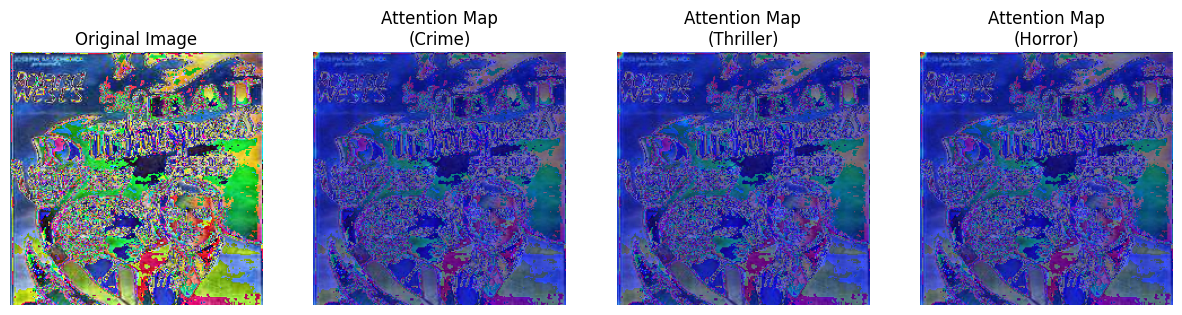

Processing imdbId: 19412


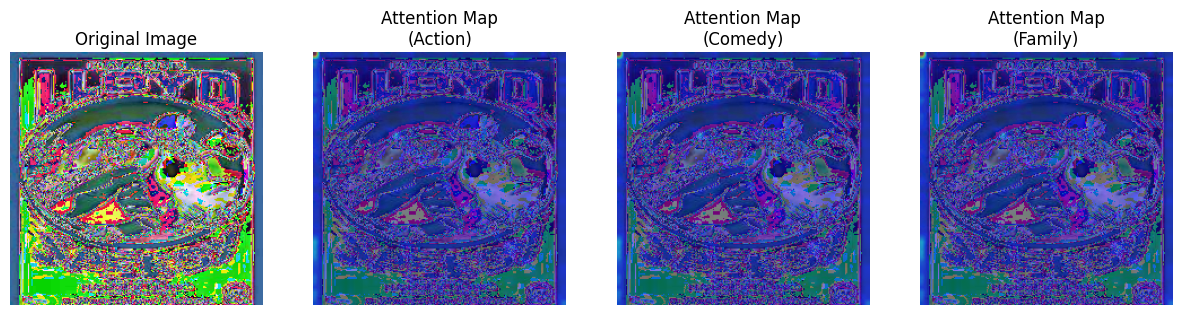

In [ ]:
# 여러 샘플 데이터 설정
imdb_ids = ["20668", "19412"]  # 예시 imdbId 리스트

# 여러 이미지를 처리 및 시각화
for imdbId in imdb_ids:
    print(f"Processing imdbId: {imdbId}")

    # 이미지 경로 설정
    sample_image_path = f"./final_sampled_dataset/{imdbId}.jpg"

    # 이미지 로드 및 전처리
    sample_image = transform(Image.open(sample_image_path).convert("RGB")).unsqueeze(0).to(device)

    # 해당 imdbId의 장르 가져오기
    if imdbId not in imdbId_to_genres:
        print(f"No genre information available for imdbId: {imdbId}")
        continue

    sample_genres = imdbId_to_genres[imdbId]  # 예: ['Comedy', 'Drama']
    genre_indices = [genre_to_idx[g] for g in sample_genres]

    # Attention Map 생성
    attention_maps = generate_attention_maps(chain_model, sample_image, genre_indices, genre_list)

    # Attention Map 시각화
    visualize_multiple_attention_maps(sample_image, attention_maps)

Processing imdbId: 20668


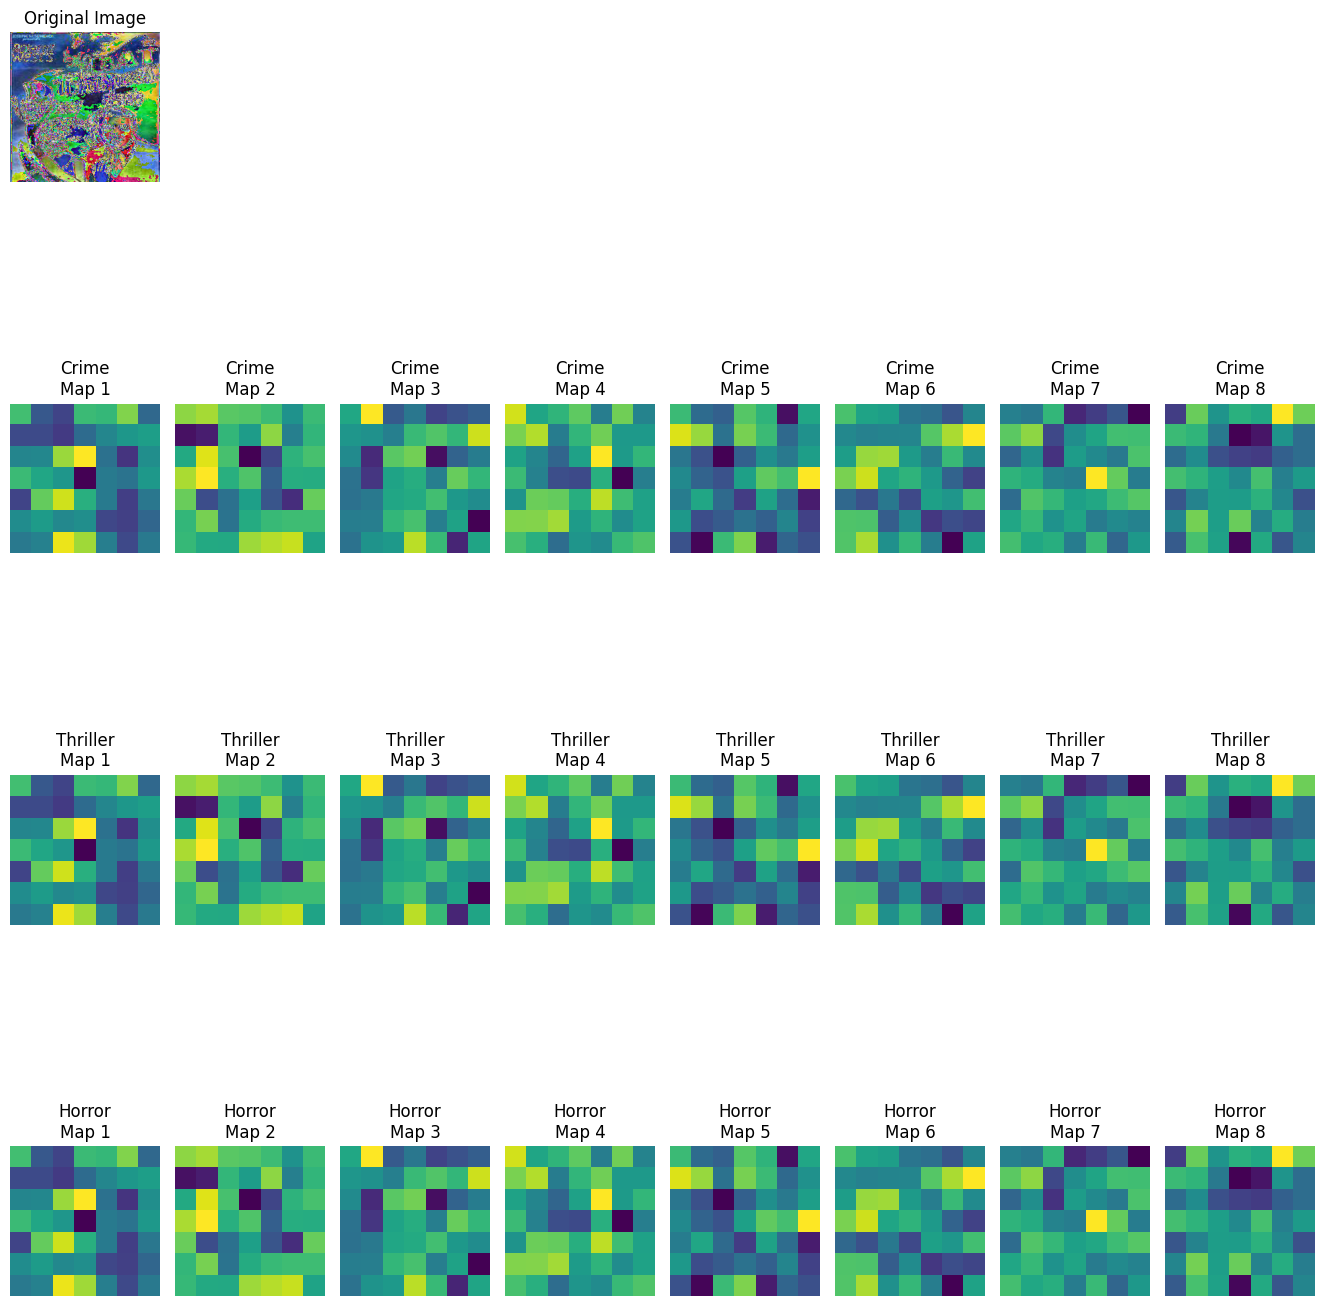

Processing imdbId: 19412


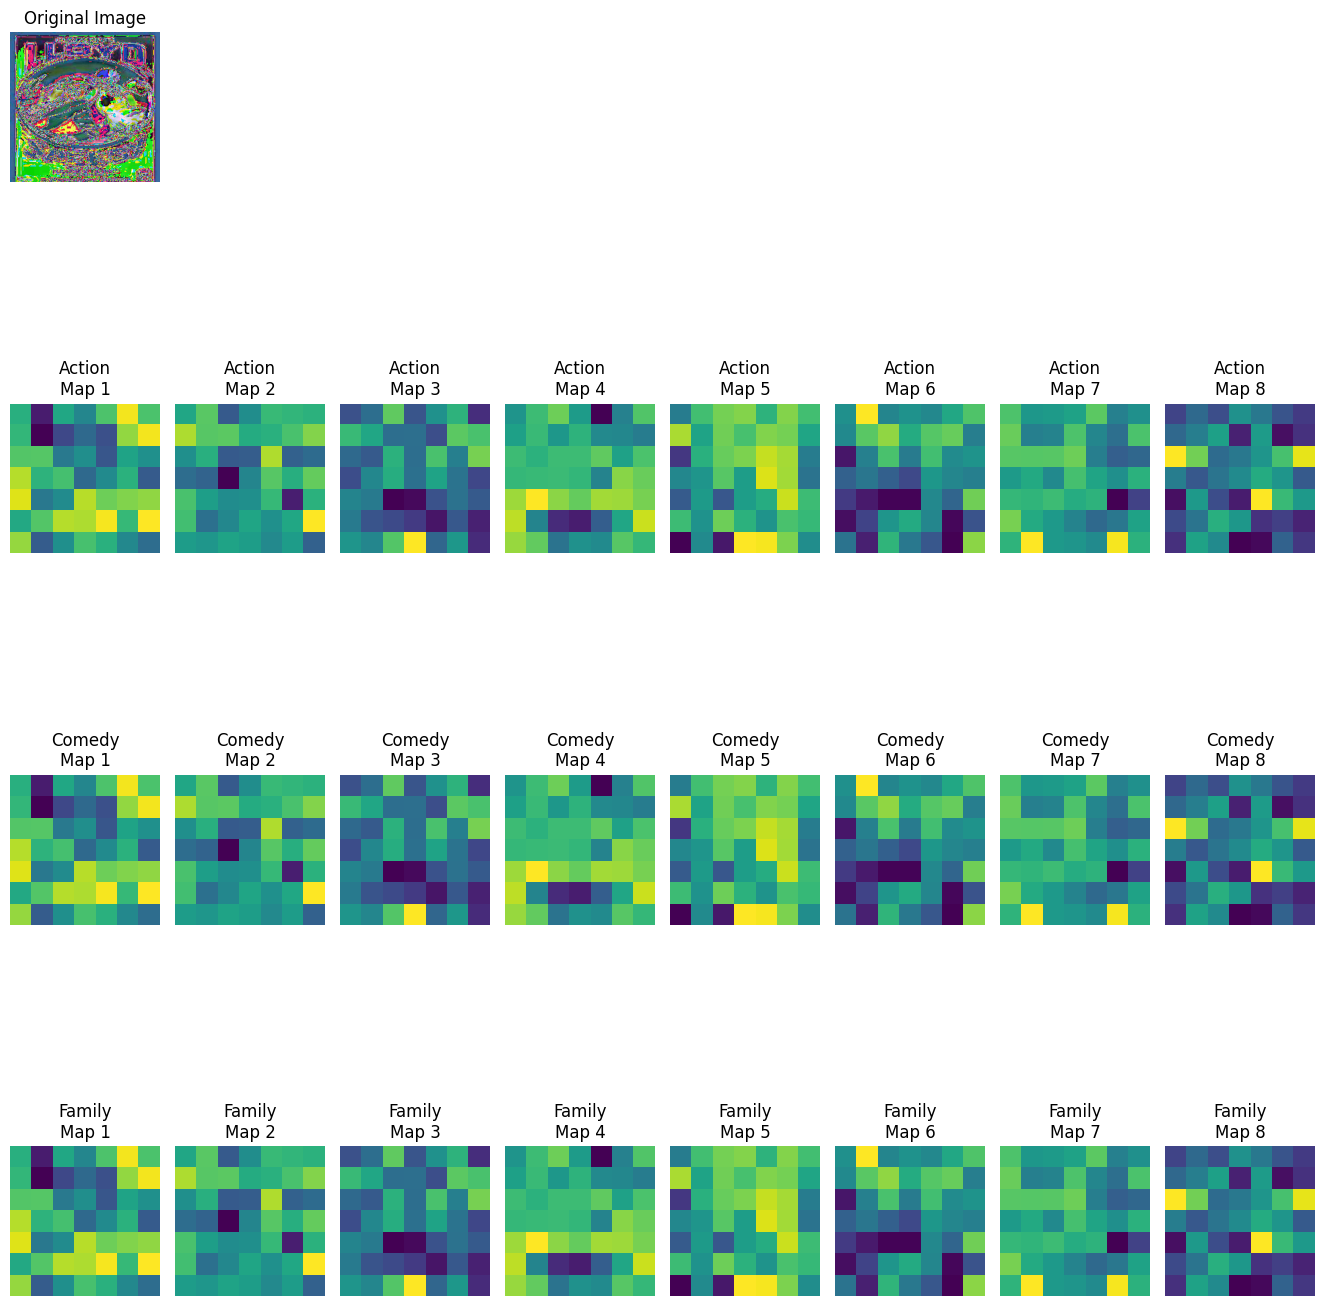

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image

# Feature Map 추출 함수
def extract_feature_maps(model, input_tensor, target_layer):
    """
    Feature Map 추출.
    model: CLIP 모델
    input_tensor: 입력 이미지 텐서 (1, 3, H, W)
    target_layer: Feature Map을 추출할 Transformer 계층
    """
    activations = []

    # Hook 설정
    def hook(module, input, output):
        if isinstance(output, tuple):
            output = output[0]  # 튜플인 경우 첫 번째 요소 선택
        activations.append(output)

    hook_handle = target_layer.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(input_tensor)

    hook_handle.remove()

    return activations[0].cpu().detach()

# Feature Map 시각화 함수
def visualize_feature_maps(feature_maps_by_genre, image_tensor, num_maps=8, seq_len=50):
    """
    장르별 Feature Map을 시각화.
    feature_maps_by_genre: {장르 이름: Feature Maps} 딕셔너리
    image_tensor: 입력 이미지 텐서
    num_maps: 시각화할 Feature Map 수 (default: 8)
    seq_len: Feature Map의 시퀀스 길이 (default: 50 for CLIP Vision Transformer)
    """
    original_image = ToPILImage()(image_tensor.cpu().squeeze(0))

    # CLS 토큰 제거 후 패치 크기를 추론
    patch_dim = int((seq_len - 1)**0.5)  # 예: 50 -> 49 -> 7 (7x7 패치)
    if patch_dim**2 != (seq_len - 1):
        raise ValueError(f"Seq_Len {seq_len} is not valid for square patches.")

    num_genres = len(feature_maps_by_genre)
    plt.figure(figsize=(15, 5 * num_genres))

    # 원본 이미지 시각화
    plt.subplot(num_genres + 1, num_maps + 1, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # 각 장르별 Feature Map 시각화
    for row, (genre, feature_maps) in enumerate(feature_maps_by_genre.items(), start=1):
        feature_maps = feature_maps.squeeze(0)  # [Seq_Len, Hidden_Dim]
        num_channels = min(num_maps, feature_maps.size(1))

        # CLS 토큰 제외
        feature_maps = feature_maps[1:]  # [Seq_Len - 1, Hidden_Dim]

        for col in range(num_channels):
            feature_map = feature_maps[:, col].reshape(patch_dim, patch_dim)  # Reshape to Patch Grid
            plt.subplot(num_genres + 1, num_maps + 1, row * (num_maps + 1) + col + 1)
            plt.imshow(feature_map.numpy(), cmap="viridis")
            plt.title(f"{genre}\nMap {col+1}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


# 장르별 Feature Map 비교
def compare_feature_maps_by_genre(model, imdb_ids, transform, target_layer, genre_list, genre_to_idx, imdbId_to_genres):
    """
    같은 imdbId에 대해 장르별 Feature Map을 비교.
    model: CLIP 모델
    imdb_ids: imdbId 리스트
    transform: 이미지 전처리 함수
    target_layer: Feature Map 추출 계층
    genre_list: 장르 이름 리스트
    genre_to_idx: 장르 -> 인덱스 매핑
    imdbId_to_genres: imdbId -> 장르 매핑
    """
    for imdbId in imdb_ids:
        print(f"Processing imdbId: {imdbId}")

        # 이미지 로드 및 전처리
        sample_image_path = f"./final_sampled_dataset/{imdbId}.jpg"
        sample_image = transform(Image.open(sample_image_path).convert("RGB")).unsqueeze(0).to(device)

        # 해당 imdbId의 장르 가져오기
        if imdbId not in imdbId_to_genres:
            print(f"No genre information available for imdbId: {imdbId}")
            continue

        sample_genres = imdbId_to_genres[imdbId]  # 예: ['Comedy', 'Drama']
        feature_maps_by_genre = {}

        # 각 장르별 Feature Map 추출
        for genre in sample_genres:
            genre_idx = genre_to_idx[genre]
            feature_maps = extract_feature_maps(model.vision_model, sample_image, target_layer)
            feature_maps_by_genre[genre] = feature_maps

        # Feature Map 시각화
        visualize_feature_maps(feature_maps_by_genre, sample_image, num_maps=8)

# 설정
imdb_ids = ["20668", "19412"]  # 예시 imdbId 리스트
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
target_layer = chain_model.vision_model.encoder.layers[-1].layer_norm2  # Feature Map 추출 계층

# 실행
compare_feature_maps_by_genre(chain_model, imdb_ids, transform, target_layer, genre_list, genre_to_idx, imdbId_to_genres)


* 같은 영화 포스터를 multi 장르로 분류할 때 각 장르마다 영화 포스터의 다른 부분에 집중 할 것이라고 가정을 하고 모델을 설정을 한 것이다
* attention map과 feature map을 보면 가정이 틀렸음을 알 수 있다

# 다른 모델과의 비교

In [ ]:
for pixel_values, labels in train_loader:
    print(f"Labels Shape: {labels.shape}")  # torch.Size([batch_size, num_genres])
    break


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Labels Shape: torch.Size([32, 16])


In [ ]:
import torch  # PyTorch 모듈 import

# GPU 메모리 해제
torch.cuda.empty_cache()

In [ ]:
from transformers import BlipForConditionalGeneration, CLIPModel, AutoModel
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, accuracy_score, coverage_error
import torch.optim as optim


In [ ]:
class ClassifierChainModel2(nn.Module):
    def __init__(self, vision_model, num_genres):
        super().__init__()
        self.vision_model = vision_model
        feature_dim = vision_model.config.hidden_size  # Vision Encoder에서 직접 추출
        self.heads = nn.ModuleList()
        for i in range(num_genres):  # num_genres에 맞게 head 생성
            input_dim = feature_dim + i
            self.heads.append(nn.Linear(input_dim, 1))  # 각 head의 출력 크기는 1

    def forward(self, pixel_values, labels=None):
        outputs = self.vision_model(pixel_values)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        chain_input = pooled_output
        logits_list = []

        for i, head in enumerate(self.heads):
            logit = head(chain_input)
            logits_list.append(logit)

            if labels is not None:
                prev_label_info = labels[:, i].unsqueeze(-1).float()
            else:
                prev_pred = (torch.sigmoid(logit) > 0.5).float()
                prev_label_info = prev_pred

            chain_input = torch.cat([chain_input, prev_label_info], dim=1)

        logits = torch.cat(logits_list, dim=1)  # 최종 logits 크기: [batch_size, num_genres]
        return logits

def evaluate_metrics2(val_labels, val_preds):
    """
    val_labels: Ground truth labels, shape [num_samples, num_classes]
    val_preds: Predicted labels (binary), shape [num_samples, num_classes]
    """
    # PyTorch 텐서인 경우 NumPy로 변환
    if isinstance(val_labels, torch.Tensor):
        val_labels = val_labels.cpu().numpy()
    if isinstance(val_preds, torch.Tensor):
        val_preds = val_preds.cpu().numpy()

    # Precision, Recall, F1 Score
    metrics = {}
    metrics['Precision (Micro)'] = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    metrics['Precision (Macro)'] = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    metrics['Recall (Micro)'] = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    metrics['Recall (Macro)'] = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    metrics['F1 Score (Micro)'] = f1_score(val_labels, val_preds, average='micro', zero_division=0)
    metrics['F1 Score (Macro)'] = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    # Hamming Loss
    metrics['Hamming Loss'] = hamming_loss(val_labels, val_preds)

    # Subset Accuracy
    metrics['Subset Accuracy'] = accuracy_score(val_labels, val_preds)

    # Coverage Error
    metrics['Coverage Error'] = coverage_error(val_labels, val_preds)

    return metrics



# 사용자 정의 모델 및 비교 대상 모델 초기화
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").vision_model
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").vision_model
florence_model = AutoModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")

# 모델에 Classifier Chain 추가
feature_dim_clip = clip_model.config.hidden_size
feature_dim_blip = blip_model.config.hidden_size
feature_dim_florence = florence_model.config.hidden_size

num_genres = 16
clip_chain_model = ClassifierChainModel2(clip_model, num_genres).to(device)
blip_chain_model = ClassifierChainModel2(blip_model, num_genres).to(device)
florence_chain_model = ClassifierChainModel2(florence_model, num_genres).to(device)


# Optimizer 설정
optimizer_clip = optim.Adam(clip_chain_model.parameters(), lr=0.0005)
optimizer_blip = optim.Adam(blip_chain_model.parameters(), lr=0.0005)
optimizer_florence = optim.Adam(florence_chain_model.parameters(), lr=0.0005)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
optimizer_chain_model = optim.Adam(chain_model.parameters(), lr=0.0005) #기존 내 모델의 oprimizer 초기화

In [ ]:
num_genres = 16
my_chain_model = ClassifierChainModel2(vision_model, num_genres).to('cuda')

In [ ]:
models = {
    "MY_Model": (my_chain_model, optimizer_chain_model),
    "ClassifierChain_CLIP": (clip_chain_model, optimizer_clip),
    "ClassifierChain_BLIP": (blip_chain_model, optimizer_blip),
    "ClassifierChain_Florence": (florence_chain_model, optimizer_florence),
}

In [ ]:
import pandas as pd
import json
import torch

# 결과 저장 파일 경로
results_file = "model_results.json"

# 기존 결과 로드 (중단 후 재시작할 경우)
try:
    with open(results_file, "r") as f:
        results = json.load(f)
except FileNotFoundError:
    results = {}  # 처음 실행 시 빈 딕셔너리

# 모델 하나씩 학습 및 평가
for name, (model, optimizer) in models.items():
    # 이미 저장된 모델은 건너뛰기
    if name in results:
        print(f"{name} already evaluated. Skipping...")
        continue

    print(f"Training and Evaluating {name}...")

    # 학습
    for epoch in range(5):  # Epoch 수 조정 가능
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        print(f"{name} Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    # 평가
    val_loss, val_labels, val_preds = evaluate(model, val_loader, criterion)
    metrics = evaluate_metrics2(val_labels, val_preds)
    results[name] = metrics  # 평가 결과 저장

    # GPU 메모리 정리
    del model
    torch.cuda.empty_cache()

    # 결과를 JSON 파일로 저장
    with open(results_file, "w") as f:
        json.dump(results, f, indent=4)
    print(f"Intermediate results saved to {results_file}")

# 최종 결과를 DataFrame으로 정리
df = pd.DataFrame(results).T
print("\nFinal Model Comparison Results:")
print(df)

Training and Evaluating MY_Model...


model.safetensors:   0%|          | 0.00/414M [00:00<?, ?B/s]

MY_Model Epoch 1, Train Loss: 0.4721
MY_Model Epoch 2, Train Loss: 0.4082
MY_Model Epoch 3, Train Loss: 0.3921
MY_Model Epoch 4, Train Loss: 0.3822
MY_Model Epoch 5, Train Loss: 0.3689
Intermediate results saved to model_results.json
Training and Evaluating ClassifierChain_CLIP...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


ClassifierChain_CLIP Epoch 1, Train Loss: 0.4570
ClassifierChain_CLIP Epoch 2, Train Loss: 0.4077
ClassifierChain_CLIP Epoch 3, Train Loss: 0.3987
ClassifierChain_CLIP Epoch 4, Train Loss: 0.3894
ClassifierChain_CLIP Epoch 5, Train Loss: 0.3772
Intermediate results saved to model_results.json
Training and Evaluating ClassifierChain_BLIP...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


ClassifierChain_BLIP Epoch 1, Train Loss: 0.4194
ClassifierChain_BLIP Epoch 2, Train Loss: 0.4065
ClassifierChain_BLIP Epoch 3, Train Loss: 0.4009
ClassifierChain_BLIP Epoch 4, Train Loss: 0.3985
ClassifierChain_BLIP Epoch 5, Train Loss: 0.3908
Intermediate results saved to model_results.json
Training and Evaluating ClassifierChain_Florence...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


ClassifierChain_Florence Epoch 1, Train Loss: 1.1127
ClassifierChain_Florence Epoch 2, Train Loss: 0.4529
ClassifierChain_Florence Epoch 3, Train Loss: 0.4351
ClassifierChain_Florence Epoch 4, Train Loss: 0.4068
ClassifierChain_Florence Epoch 5, Train Loss: 0.3813
Intermediate results saved to model_results.json

Final Model Comparison Results:
                          Precision (Micro)  Precision (Macro)  \
MY_Model                           0.504762           0.556693   
ClassifierChain_CLIP               0.461078           0.481231   
ClassifierChain_BLIP               0.611111           0.147436   
ClassifierChain_Florence           0.418685           0.418417   

                          Recall (Micro)  Recall (Macro)  F1 Score (Micro)  \
MY_Model                        0.138743        0.114211          0.217659   
ClassifierChain_CLIP            0.100785        0.093669          0.165414   
ClassifierChain_BLIP            0.028796        0.017706          0.055000   
Classifier

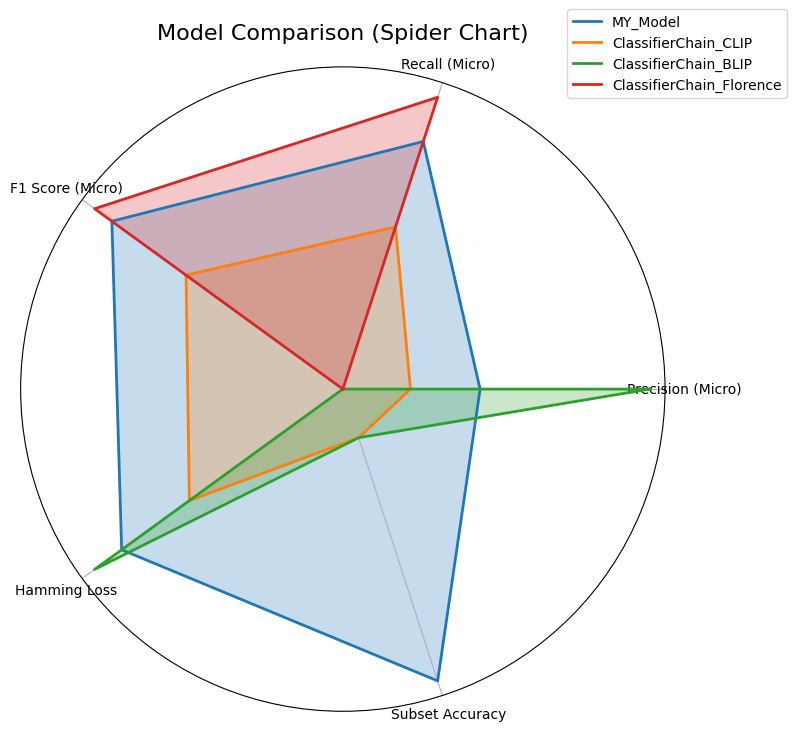

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 주요 지표 선택
metrics = ["Precision (Micro)", "Recall (Micro)", "F1 Score (Micro)",
           "Hamming Loss", "Subset Accuracy"]
models = df.index.tolist()

# 데이터를 정규화 (0~1 사이로 변환) - 스파이더 차트에 적합하게 만들기
normalized_data = df[metrics].copy()
for col in metrics:
    if col == "Hamming Loss":  # Hamming Loss는 낮을수록 좋으므로 반대로 정규화
        normalized_data[col] = 1 - (normalized_data[col] - normalized_data[col].min()) / (normalized_data[col].max() - normalized_data[col].min())
    else:  # 다른 지표는 높을수록 좋으므로 그대로 정규화
        normalized_data[col] = (normalized_data[col] - normalized_data[col].min()) / (normalized_data[col].max() - normalized_data[col].min())

# 스파이더 차트 데이터 준비
values = normalized_data.values
num_vars = len(metrics)

# 각 지표의 각도를 계산
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 마지막 지표에서 시작점으로 돌아오기 위해 추가

# 스파이더 차트 그리기
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 모델별로 데이터 추가
for idx, model_name in enumerate(models):
    data = values[idx].tolist()
    data += data[:1]  # 시작점으로 돌아오기 위해 추가
    ax.plot(angles, data, linewidth=2, label=model_name)
    ax.fill(angles, data, alpha=0.25)  # 내부 채우기

# 각 지표 레이블 설정
ax.set_yticks([])  # 내부 원 레이블 제거
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=10)

# 제목 및 범례 설정
plt.title("Model Comparison (Spider Chart)", fontsize=16, pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=10)
plt.tight_layout()
plt.show()


# 환경 확인

In [ ]:
# GPU 정보 확인
!nvidia-smi

Tue Dec 10 13:16:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              47W /  70W |   6629MiB / 15360MiB |     52%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# OS 버전 확인
!cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [ ]:
import torch
import torchvision

# PyTorch 및 Torchvision 버전 확인
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
